In [1]:
%load_ext autoreload
%autoreload 2

In [103]:
import os, sys
import dill as pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from sklearn.model_selection import train_test_split

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import SuperSpeculator
import popsed
popsed.set_matplotlib(style='JL', usetex=True, dpi=80, fontsize=16)
from popsed import prior

In [104]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [105]:
name = 'NMF'

In [106]:
params = np.load(f'./train_sed_{name}/{name.lower()}_seds/fsps.{name}.v0.2.theta_unt.seedtest.npy')[:10000]
# params = np.hstack([params[:, 1:], params[:, :1]])
# exclude stellar mass (1 M_\dot), remain redshift (i.e., length of SFH)
wave = np.load(f'./train_sed_{name}/{name.lower()}_seds/fsps.wavelength.npy')
print('Number of samples:', params.shape[0])

Number of samples: 10000


In [108]:
from popsed.nde import _inv_beta_cdf

In [110]:
for i in range(1, 4):
    params[:, i:i+1] = _inv_beta_cdf(params[:, i:i+1], 4 - i, 1)

In [87]:
# params = params[params[:, -1] < 0.5]

In [111]:
params = np.hstack([params[:, 0:1], 
                    prior.FlatDirichletPrior(4).transform(params[:, 1:4]), 
                    params[:, 4:]
                   ])

In [90]:
n_samples = len(params)
kappas = np.vstack([beta(3, 1).rvs(n_samples), beta(2, 1).rvs(n_samples), beta(1, 1).rvs(n_samples)]).T
betas = prior.FlatDirichletPrior(4).transform(kappas)
params[:, 1:5] = betas

In [112]:
if name == 'NMF':
    from popsed.models import NMF
    model = NMF(burst=True, peraa=True)
else:
    from popsed.models import NMF_ZH
    model = NMF_ZH(burst=True, peraa=True)

Initialize NMF-based SPS model
Input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index


In [114]:
sfr = np.zeros(len(params))
age = np.zeros(len(params))

for i in range(len(params)):
    tt = params[i]
    sfr[i] = model.avgSFR(tt[:-1], zred=tt[-1], dt=1)
    age[i] = model.tage_MW(tt[:-1], zred=tt[-1])
    
if name == 'NMF_ZH':
    zmw = np.zeros(len(params))
    for i in range(len(params)):
        tt = params[i]
        zmw[i] = model.Z_MW(tt[:-1], zred=tt[-1])

In [115]:
if name == 'NMF_ZH':
    logzsol = np.log10(zmw / 0.019)
else:
    logzsol = params[:, 7]
redshift = params[:, -1]

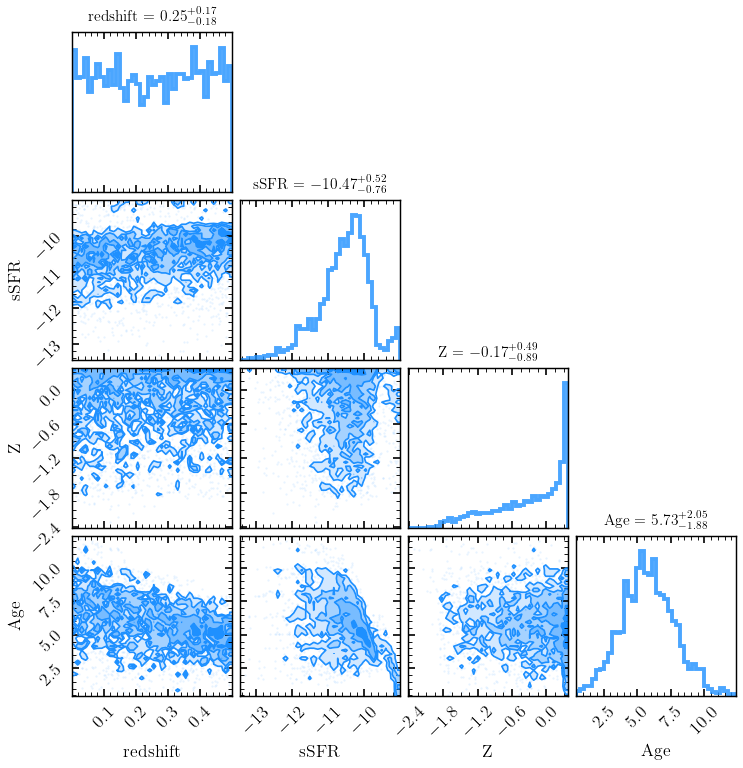

In [94]:
figure = corner.corner(np.vstack([redshift, np.log10(sfr), logzsol, age]).T, 
                  labels=['redshift', 'sSFR', 'Z', 'Age'], bins=40,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.3, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 14}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

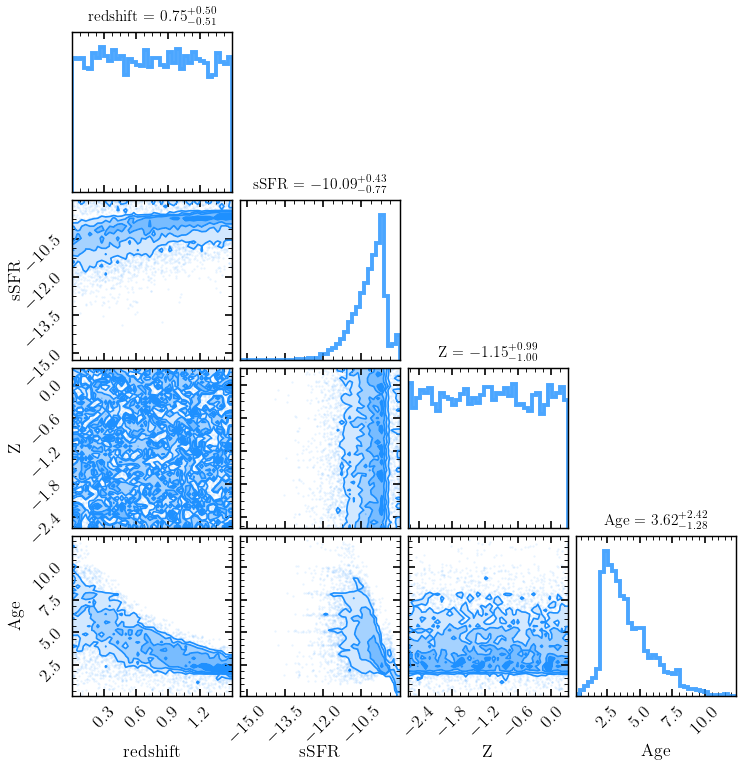

In [116]:
figure = corner.corner(np.vstack([redshift, np.log10(sfr), logzsol, age]).T, 
                  labels=['redshift', 'sSFR', 'Z', 'Age'], bins=40,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.3, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 14}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

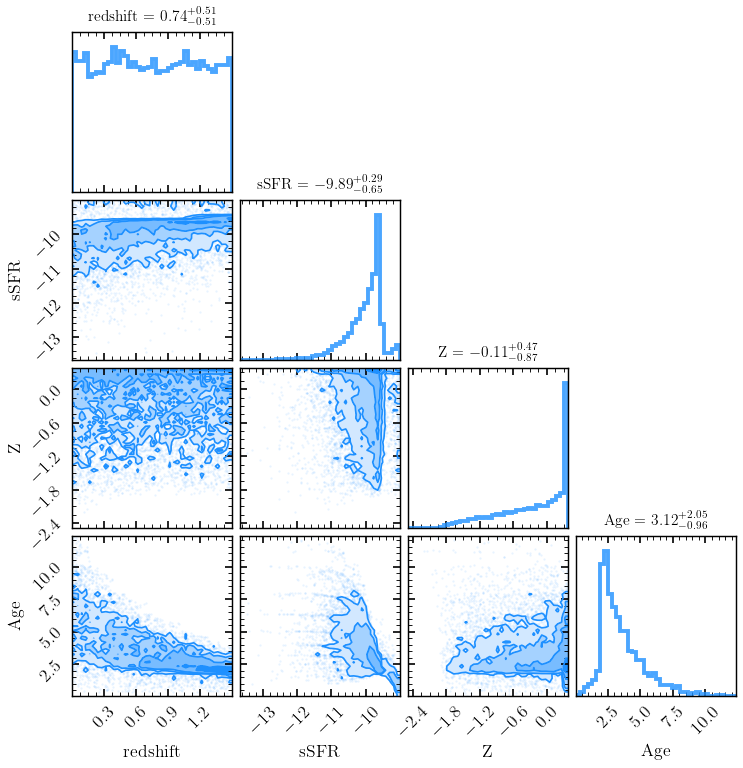

In [44]:
# nmf-zh
figure = corner.corner(np.vstack([redshift, np.log10(sfr), logzsol, age]).T, 
                  labels=['redshift', 'sSFR', 'Z', 'Age'], bins=40,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.3, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 14}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

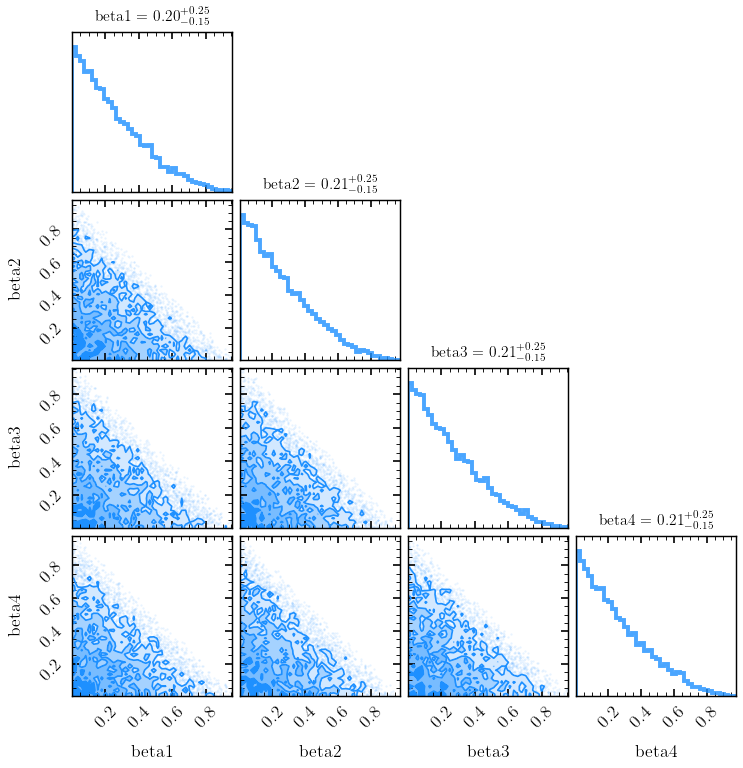

In [113]:
figure = corner.corner(params[:, 1:5], 
                       labels=['beta1', 'beta2', 'beta3', 'beta4'],
#                   labels=['redshift', 'sSFR', 'Z', 'Age'], 
                       bins=40,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.3, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 14}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

---

In [51]:
from scipy.stats import beta

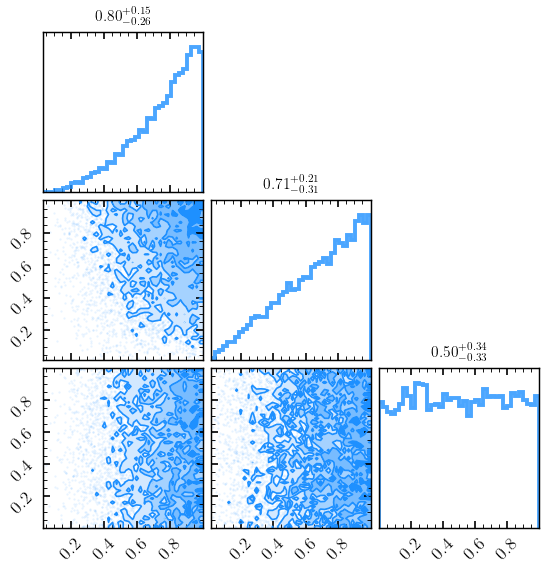

In [55]:
figure = corner.corner(np.vstack([z1, z2, z3]).T, 
#                   labels=['redshift', 'sSFR', 'Z', 'Age'], 
                       bins=40,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.3, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 14}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

# ax = figure.get_axes()[2]
# ax.legend(handles=[k_line, b_line], fontsize=17, bbox_to_anchor=(0., 1.0, 1.3, .0))

# plt.suptitle('GAMA DR3 aperture-matched photometry, SDSS $ugriz$', y=1.06)

In [56]:
zs = np.vstack([z1, z2, z3]).T

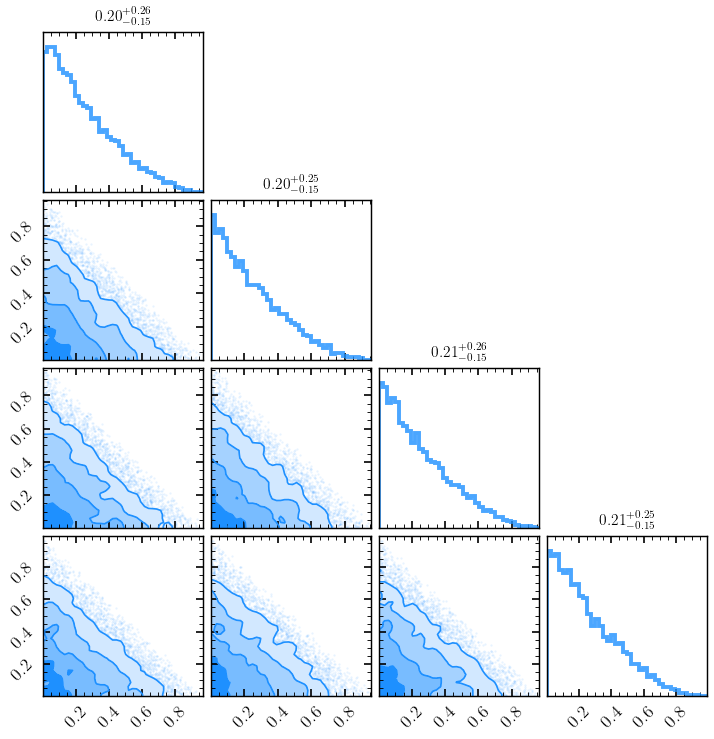

In [60]:
figure = corner.corner(prior.FlatDirichletPrior(4).transform(zs), 
#                   labels=['redshift', 'sSFR', 'Z', 'Age'], 
                       bins=40,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=1, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 14}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

# ax = figure.get_axes()[2]
# ax.legend(handles=[k_line, b_line], fontsize=17, bbox_to_anchor=(0., 1.0, 1.3, .0))

# plt.suptitle('GAMA DR3 aperture-matched photometry, SDSS $ugriz$', y=1.06)

In [59]:
prior.FlatDirichletPrior(4).transform(zs).sum()

10000.0